In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import torch
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

In [2]:
from Scripts.Configs.ConfigClass import Config

In [3]:
config = Config(r'C:\Users\fardin\Projects\ColorIntelligence\Scripts\Configs\Config.json')

In [4]:
# train_df = pd.read_csv(r'C:\Users\fardin\Projects\ColorIntelligence\data\Amazon-Review\train.csv')
# test_df = pd.read_csv(r'C:\Users\fardin\Projects\ColorIntelligence\data\Amazon-Review\test.csv')
# train_df[:50000].to_csv(r'C:\Users\fardin\Projects\ColorIntelligence\data\Amazon-Review\train_sm.csv', ',', index=False)
# test_df[:5000].to_csv(r'C:\Users\fardin\Projects\ColorIntelligence\data\Amazon-Review\test_sm.csv', ',', index=False)
train_df = pd.read_csv(r'C:\Users\fardin\Projects\ColorIntelligence\data\Amazon-Review\train_sm.csv')
test_df = pd.read_csv(r'C:\Users\fardin\Projects\ColorIntelligence\data\Amazon-Review\test_sm.csv')

In [5]:
train_df.columns = ['Polarity', 'Title', 'Review']
test_df.columns = ['Polarity', 'Title', 'Review']

In [6]:
train_df = train_df[['Polarity', 'Review']]
test_df = test_df[['Polarity', 'Review']]

In [7]:
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx

In [8]:
train_df['Review'][0]

"I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."

In [9]:
# from Scripts.DataManager.GraphConstructor.CoOccurrenceGraphConstructor import CoOccurrenceGraphConstructor
import spacy
import numpy as np
from typing import Dict
import torch

In [10]:
nlp = spacy.load(config.spacy.pipeline)
doc = nlp(train_df['Review'][0])

In [34]:
doc[0].lower_

'i'

In [ ]:
unique_words = []
for token in doc:
    unique_words.append(token.lemma_)
unique_words = list(set(unique_words))
unique_map = pd.Series(range(len(unique_words)), index=unique_words, dtype=int)
token_lemmas = [t.lemma_ for t in doc]

In [13]:
n_gram = 4
dense_mat = torch.zeros((len(unique_words), len(unique_words)), dtype=torch.float32)
for i in range(len(token_lemmas)-n_gram):
    n_gram_data = set(token_lemmas[i:i+n_gram])
    n_gram_ids = [unique_map[val] for val in n_gram_data]
    grid_ids = torch.tensor([(x,y) for x in n_gram_ids for y in n_gram_ids])
    dense_mat[grid_ids[:,0], grid_ids[:,1]] += 1
dense_mat = torch.nn.functional.normalize(dense_mat)

sparse_mat = dense_mat.to_sparse_coo()

In [45]:
unique_word_ids = [nlp.vocab.strings[unique_words[i]] for i in range(len(unique_words))]
unique_word_vectors = torch.zeros((len(unique_words), nlp.vocab.vectors_length), dtype=torch.float32)
for i in range(len(unique_words)):
    word_id = unique_word_ids[i]
    if word_id in nlp.vocab.vectors:
        unique_word_vectors[i] = torch.tensor(nlp.vocab.vectors[word_id])
    else:
        # Write functionality to resolve word vector ((for now we use random vector)) 1000
        # use pretrain model to generate vector (heavy)
        # Over-fit a smaller model over spacy dictionary
        unique_word_vectors[i] = torch.zeros((nlp.vocab.vectors_length,), dtype=torch.float32)


In [57]:
sparse_mat.values().shape

torch.Size([597])

In [58]:
data_edge_index = sparse_mat.indices()
data_edge_attr = sparse_mat.values()
data_x = unique_word_vectors
doc_graph = Data(x=data_x, edge_index=data_edge_index, edge_attr=data_edge_attr)

{0: Text(0.3381743827504702, -0.03566575897836349, 'the'),
 1: Text(-0.1667746276442039, 0.25368921411741435, 'to'),
 2: Text(-0.33444338804483503, 0.33999134570220024, 'money'),
 3: Text(0.2604016965562642, -0.25768131528471855, 'only'),
 4: Text(0.7133178998334065, -0.39032665588568716, 'masterpiece'),
 5: Text(-0.24801763919907688, -0.802536455994834, 'every'),
 6: Text(0.049014844695748794, 0.9841636423699137, 'now'),
 7: Text(0.5298222055824278, 0.013194908301909785, 'price'),
 8: Text(-0.21356031891016153, 0.11187199655359849, 'staggering'),
 9: Text(-0.25857197543692706, -0.24510199811492098, 'a'),
 10: Text(0.016652129255559523, -0.17607284428647038, 'that'),
 11: Text(-0.6170899581726528, -0.04243726061243314, 'but'),
 12: Text(-0.05244960694151095, -0.7988500319364782, 'worth'),
 13: Text(0.515583855536289, -0.7015957620104482, 'Mitsuda'),
 14: Text(0.21102742895218413, -0.6248798555893414, 'opinino'),
 15: Text(-0.39098231405635137, 0.19518888254860017, 'must'),
 16: Text(0.

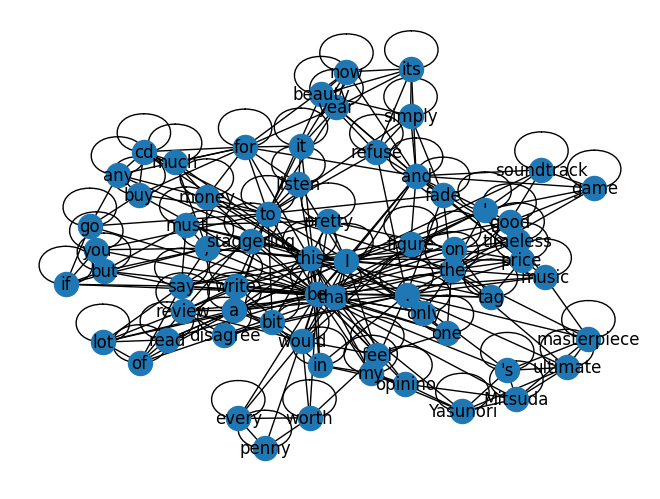

In [70]:
g = to_networkx(doc_graph, to_undirected=True)
layout = nx.spring_layout(g)
nx.draw(g, pos=layout)
unique_words_dict = {i: unique_words[i] for i in range(len(unique_words))}
nx.draw_networkx_labels(g, pos=layout, labels=unique_words_dict)